In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import resnet50

# 1. Backbone (ResNet-50)
class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        resnet = resnet50(pretrained=True)
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x = self.stem(x)
        C2 = self.layer1(x)
        C3 = self.layer2(C2)
        C4 = self.layer3(C3)
        C5 = self.layer4(C4)
        return C2, C3, C4, C5

In [ ]:
class FPN(nn.Module):
    def __init__(self, C2, C3, C4, C5, out_channels=256):
        super(FPN, self).__init__()

        # Top-down layers
        self.P5 = nn.Conv2d(C5, out_channels, kernel_size=1, stride=1, padding=0)
        self.P4 = nn.Conv2d(C4, out_channels, kernel_size=1, stride=1, padding=0)
        self.P3 = nn.Conv2d(C3, out_channels, kernel_size=1, stride=1, padding=0)
        self.P2 = nn.Conv2d(C2, out_channels, kernel_size=1, stride=1, padding=0)

        # Lateral layers
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode="nearest")
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode="nearest")
        self.P2_upsampled = nn.Upsample(scale_factor=2, mode="nearest")

        # Smoothing layers
        self.P4_smooth = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.P3_smooth = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, C2, C3, C4, C5):
        P5 = self.P5(C5)

        P4 = self.P4(C4) + self.P4_upsampled(P5)
        P4 = self.P4_smooth(P4)

        P3 = self.P3(C3) + self.P3_upsampled(P4)
        P3 = self.P3_smooth(P3)

        P2 = self.P2(C2) + self.P2_upsampled(P3)

        return P2, P3, P4, P5


In [ ]:
class PanopticHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(PanopticHead, self).__init__()
        self.semantic_branch = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0)
        )
        # For instance branch, we assume it predicts class-agnostic masks
        self.instance_branch = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        semantic_logits = self.semantic_branch(x)
        instance_logits = self.instance_branch(x)
        return semantic_logits, instance_logits


In [ ]:
# 4. Full Model
class PanopticSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(PanopticSegmentationModel, self).__init__()
        self.backbone = ResNetBackbone()
        self.fpn = FPN(256, 512, 1024, 2048)
        self.panoptic_head = PanopticHead(256, num_classes)

    def forward(self, x):
        C2, C3, C4, C5 = self.backbone(x)
        P2, P3, P4, P5 = self.fpn(C2, C3, C4, C5)
        # For simplicity, we just use the highest resolution feature map (P2)
        semantic_logits, instance_logits = self.panoptic_head(P2)
        return semantic_logits, instance_logits

# 5. Dummy Forward Pass
model = PanopticSegmentationModel(num_classes=21)  # Assume 21 classes for example
dummy_input = torch.randn(1, 3, 512, 512)  # Batch size of 1, 3 channels, 512x512 image
semantic_output, instance_output = model(dummy_input)
print(semantic_output.shape, instance_output.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


torch.Size([1, 21, 128, 128]) torch.Size([1, 1, 128, 128])


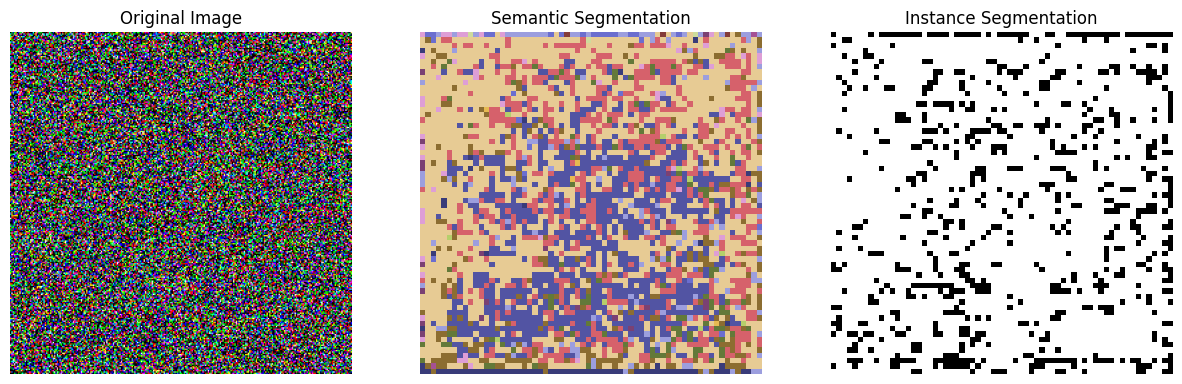

In [ ]:
# Initialize the model
model = PanopticSegmentationModel(num_classes=21)
# Switch the model to eval mode
model.eval()

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 256, 256)  # Batch size of 1, 3 channels, 256x256 image

# Run the model with the dummy input
with torch.no_grad():
    semantic_output, instance_output = model(dummy_input)

# Convert the outputs to probabilities using softmax for semantic segmentation
semantic_probs = torch.nn.functional.softmax(semantic_output, dim=1)
# Take the maximum class probability for each pixel to get the predicted class
_, semantic_pred = torch.max(semantic_probs, dim=1)

# For instance segmentation, we'll threshold the logits to get binary mask predictions
instance_pred = torch.sigmoid(instance_output) > 0.5

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image (dummy input in this case)
axs[0].imshow(dummy_input[0].permute(1, 2, 0).numpy())
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the semantic segmentation
axs[1].imshow(semantic_pred[0].numpy(), cmap='tab20b')
axs[1].axis('off')
axs[1].set_title('Semantic Segmentation')

# Display the instance segmentation
axs[2].imshow(instance_pred[0].squeeze().numpy(), cmap='gray')
axs[2].axis('off')
axs[2].set_title('Instance Segmentation')

plt.show()


In [ ]:
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])


In [ ]:
from torchvision import transforms
from PIL import Image

# Load the image
image = Image.open("path_to_your_image.jpg").convert("RGB")

# Define the transformations
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    normalize,
])

# Preprocess the image
image_tensor = preprocess(image)

# Add the batch dimension
image_tensor = image_tensor.unsqueeze(0)  # Create a batch of 1

# Move the tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Model inference
model.to(device)
with torch.no_grad():
    semantic_output, instance_output = model(image_tensor)


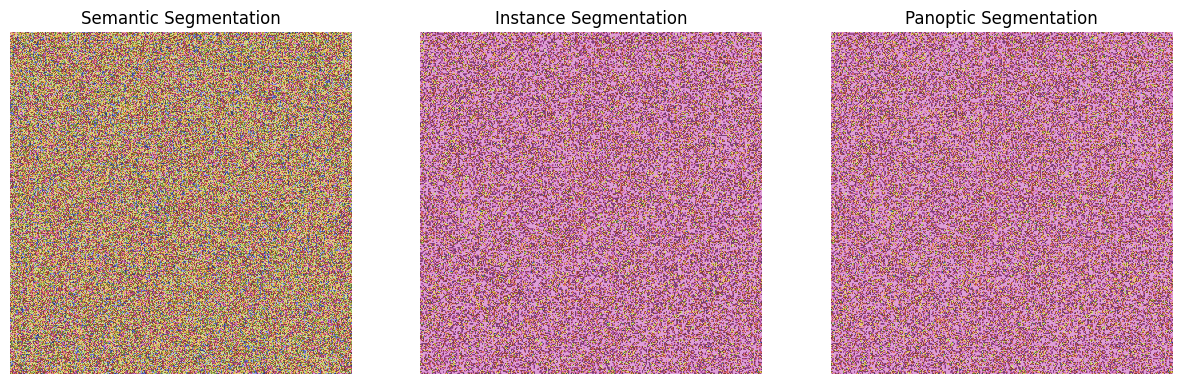

In [ ]:
import numpy as np

# Dummy data for demonstration
semantic_output = torch.randn(1, 21, 256, 256)  # (batch_size, num_classes, height, width)
instance_output = torch.randn(1, 5, 256, 256)  # (batch_size, num_instances, height, width)

# Convert the semantic output to class predictions
_, semantic_pred = torch.max(semantic_output, dim=1)  # (batch_size, height, width)

# Threshold the instance outputs to get binary masks
instance_masks = torch.sigmoid(instance_output) > 0.5  # (batch_size, num_instances, height, width)

# Convert instance masks to non-overlapping instance labels
instance_labels = torch.zeros_like(semantic_pred)  # (batch_size, height, width)
for batch in range(instance_output.shape[0]):  # Loop over batch
    for i in range(instance_output.shape[1]):  # Loop over instances
        # Instance 0 is reserved for 'no instance'
        instance_labels[batch][instance_masks[batch, i]] = i + 1

# Combine semantic and instance information to create panoptic segmentation
panoptic_seg = semantic_pred.numpy() + (instance_labels.numpy() * 1000)  # Arbitrary scaling to separate instances

# Visualization (with matplotlib)

plt.figure(figsize=(15, 5))

# Display the semantic segmentation
plt.subplot(1, 3, 1)
plt.imshow(semantic_pred[0].cpu().numpy(), cmap='tab20b')  # Assuming you're using a CPU for this
plt.axis('off')
plt.title('Semantic Segmentation')

# Display the instance segmentation
plt.subplot(1, 3, 2)
plt.imshow(instance_labels[0].cpu().numpy(), cmap='tab20b')  # Assuming you're using a CPU for this
plt.axis('off')
plt.title('Instance Segmentation')

# Display the panoptic segmentation
plt.subplot(1, 3, 3)
plt.imshow(panoptic_seg[0], cmap='tab20b')  # Assuming you're using a CPU for this
plt.axis('off')
plt.title('Panoptic Segmentation')

plt.show()

